In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from tqdm import tqdm
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
def data_generator(root, batch_size):
    train_set = datasets.MNIST(root=root, train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor()
                                  #  transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.MNIST(root=root, train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor()
                                  # transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

# download data
train_loader, test_loader = data_generator('/', 4)

In [6]:
def to_temporal(batch, step=0.1):
  """
  Convert a batch of mnist images into temporal format with timing
  determined by the intensity of the pixel from darkest to lightest.

  Args:
      batch (torch tensor): batch of mnist images.
      step (float): determines the number of time intervals with number
          of intervals given by 1/step.
  
  Returns:
      torch tensor of the batch of images in temporal format.
  """
  buckets, _ = torch.sort(1 - torch.arange(start=0, end=1, step=step))
  # bucketize into desired number of temporal bins
  bucket_batch = torch.bucketize(batch, buckets)
  # one hot encode these bins and flip so that dark appears first
  temp_batch = torch.flip(F.one_hot(bucket_batch), [4])
  return temp_batch



Original Image


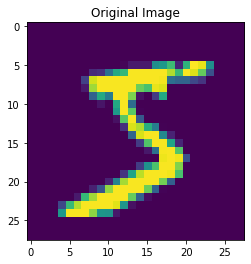


Temporal version of image


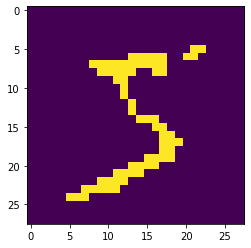

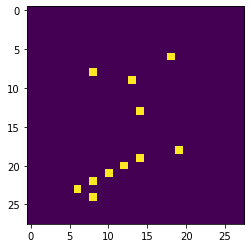

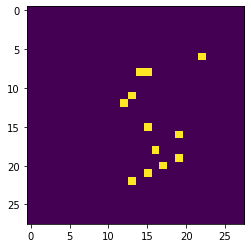

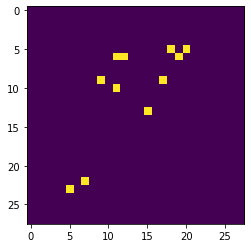

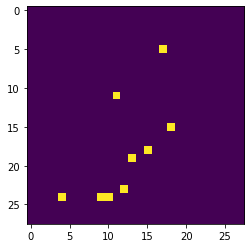

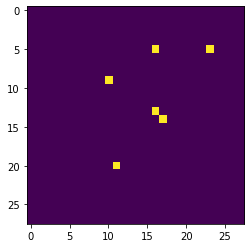

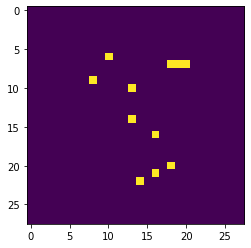

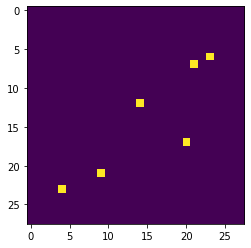

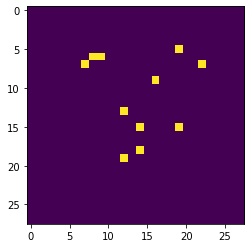

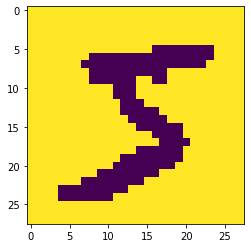

In [17]:
# plot a sample temporal image
for batch_idx, (data, target) in enumerate(train_loader):
  break
print('Original Image')
plt.imshow(data[0].squeeze(0).numpy())
plt.title('Original Image')
plt.show()
test = to_temporal(data)
print('\nTemporal version of image')
for i in range(10):
  x = test[0,0,:,:,i].numpy()
  plt.imshow(x)
  plt.show()

In [21]:
# LSTM model
torch.manual_seed(3)

class LSTM(nn.Module):
    def __init__(self, input_size, output_size, nhid, f_bias=True):
        super(LSTM, self).__init__()
        self.nhid = nhid
        self.lstm = nn.LSTM(input_size, nhid, batch_first=True)
        self.linear = nn.Linear(nhid, output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        h0 = torch.zeros(1, inputs.size(0), self.nhid).to(device) 
        c0 = torch.zeros(1, inputs.size(0), self.nhid).to(device)
        y1, _ = self.lstm(inputs, (h0, c0))  # input should have dimension (B, S, I)
        o = self.linear(y1)
        return o

In [22]:
model = LSTM(28*28, 10, 125)
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
s = nn.Sigmoid()

BATCH_SIZE = 256
VALIDATION_FREQ = 1
PATH = '/model_weights'

NUM_EPOCHS = 30
seq_len = 20
train_loader, test_loader = data_generator('/', BATCH_SIZE)

best_spiking_acc = 0
loss_ls = []
spiking_acc_ls = []
spike_time_ls = []

print('################## TRAINING ##################')
print('Training {} epochs in batches of size {}'.format(NUM_EPOCHS, BATCH_SIZE))
print('##############################################\n')

time.sleep(0.2)
for epoch in tqdm(range(NUM_EPOCHS)):
    for batch_idx, (batch, targets) in enumerate(train_loader):
        ######################## TRAIN A BATCH ########################
        batch_size = batch.size(0)
        temp_batch = to_temporal(batch, step=0.05)
        temp_batch = temp_batch.view(batch_size, 28*28, seq_len).permute(0,2,1)
        temp_batch, targets = temp_batch.to(device), targets.to(device)

        # learn through network
        model.train()
        optimiser.zero_grad()
        out = model(temp_batch.float())
        out = s(out)
        
        # grab indixes of first spikes
        with torch.no_grad():
            spikes = (out > 0.95) * 1
            spikes_red = spikes.sum(axis=2)  # find rows with no spikes
            # set seqs with no spikes to spike on last output
            spikes_red[torch.sum(spikes_red, axis=1) == 0, -1] = 1
            # find indexes of first spike in seqs and pass it back
            first_spike_idx = torch.argmax(spikes_red, dim=1, keepdim=True)
            first_spike_idx = first_spike_idx.repeat(1, 10).unsqueeze(1)
 
        preds = torch.gather(out, 1, first_spike_idx)  
        preds = preds.squeeze(1)
        
        loss = criterion(preds, targets)
        loss_ls.append(loss.item())
        loss.backward()
        optimiser.step()

    ######################## VALIDATION SET ########################
    if epoch % VALIDATION_FREQ == 0:
      temp_spiking_acc_ls = []
      temp_spike_time_ls = []
      model.eval()
      with torch.no_grad():
          for batch, targets in test_loader:
              batch_size = batch.size(0)
              temp_batch = to_temporal(batch, step=0.05)
              temp_batch = temp_batch.view(batch_size, 28*28, seq_len).permute(0,2,1)
              temp_batch, targets = temp_batch.to(device), targets.to(device)

              out = model(temp_batch.float())
              out = s(out)
              
              # generate tensor of spikes
              spikes = (out > 0.95) * 1

              spikes_red = spikes.sum(axis=2)  # find rows with no spikes
              # set seqs with no spikes to spike on last output
              spikes_red[torch.sum(spikes_red, axis=1) == 0, -1] = 1
              # find indexes of first spike in seqs and pass it back
              first_spike_idx = torch.argmax(spikes_red, dim=1, keepdim=True)
              batch_spike_time = torch.mean(first_spike_idx.float())
              first_spike_idx = first_spike_idx.repeat(1, 10).unsqueeze(1)
  
              preds = torch.gather(out, 1, first_spike_idx)
              preds = preds.squeeze(1)

              preds = torch.argmax(preds, dim=1)

              # spiking accuracy
              spiking_acc_val = (torch.sum(targets == preds)/batch_size).item()
              temp_spiking_acc_ls.append(spiking_acc_val)

              # store mean spike times
              temp_spike_time_ls.append(batch_spike_time.item())

      # save model if better than current best
      val_set_spiking_acc = np.mean(temp_spiking_acc_ls)
      val_set_spike_time = np.mean(temp_spike_time_ls)
      if val_set_spiking_acc > best_spiking_acc:
          # save the model 
          best_spiking_acc = val_set_spiking_acc
          torch.save(model.state_dict(), PATH)
      spiking_acc_ls.append(val_set_spiking_acc)
      spike_time_ls.append(val_set_spike_time)
      

time.sleep(0.2)    
    
    
print('\nFinal loss:', best_spiking_acc)

################## TRAINING ##################
Training 30 epochs in batches of size 256
##############################################



100%|██████████| 30/30 [35:56<00:00, 71.89s/it]



Final loss: 0.95419921875


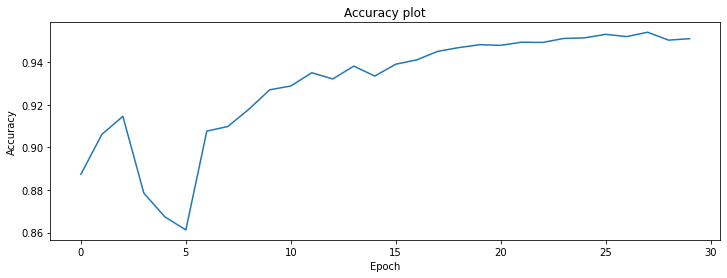

In [23]:
plt.figure(figsize=(12,4))
plt.plot(spiking_acc_ls)
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

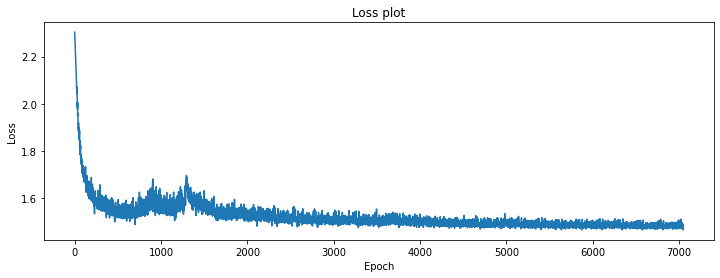

In [24]:
plt.figure(figsize=(12,4))
plt.plot(loss_ls)
plt.title('Loss plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

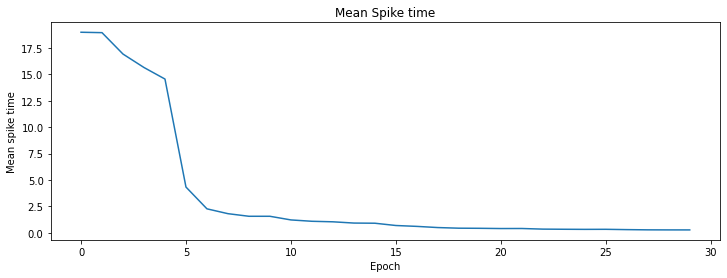

In [25]:
plt.figure(figsize=(12,4))
plt.plot(spike_time_ls)
plt.title('Mean Spike time')
plt.xlabel('Epoch')
plt.ylabel('Mean spike time')
plt.show()

In [19]:
# unit test for spiking logic

############ TEST CASE ############
# batch size = 3, seq len = 3, num outputs = 4 
out = torch.tensor([[[0.5155, 0.4866, 0.5293, 0.4982],
                     [0.6167, 0.9932, 0.5343, 0.5055],
                     [0.7138, 0.9959, 0.5277, 0.9173]],

                    [[0.9501, 0.4929, 0.5270, 0.5144],
                     [0.5108, 0.9840, 0.5448, 0.5071],
                     [0.5051, 0.9801, 0.5274, 0.5020]],
                    
                    [[0.5501, 0.4929, 0.5270, 0.5144],
                     [0.5108, 0.7840, 0.5448, 0.5071],
                     [0.5051, 0.7801, 0.5274, 0.5020]]])

# expected outputs
first_spike_idx = torch.tensor([[[1, 1, 1, 1]],

                                [[0, 0, 0, 0]],
                                
                                [[2, 2, 2, 2]]])

preds = torch.tensor([[[0.6167, 0.9932, 0.5343, 0.5055]],

                      [[0.9501, 0.4929, 0.5270, 0.5144]],
                      
                      [[0.5051, 0.7801, 0.5274, 0.5020]]])

# evaluate outputs
seq_len = 3
spikes = (out > 0.95) * 1
spikes_red = spikes.sum(axis=2)
# set seqs with no spikes to spike on last output
spikes_red[torch.sum(spikes_red, axis=1) == 0, -1] = 1
first_spike_idx_obs = torch.argmax(spikes_red, dim=1, keepdim=True)
first_spike_idx_obs = first_spike_idx_obs.repeat(1,4).unsqueeze(1)
            
preds_obs = torch.gather(out, 1, first_spike_idx_obs)  

print(first_spike_idx_obs)
print(preds_obs)
             

tensor([[[1, 1, 1, 1]],

        [[0, 0, 0, 0]],

        [[2, 2, 2, 2]]])
tensor([[[0.6167, 0.9932, 0.5343, 0.5055]],

        [[0.9501, 0.4929, 0.5270, 0.5144]],

        [[0.5051, 0.7801, 0.5274, 0.5020]]])
